In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import chi2_contingency


In [2]:
print(sys.version)

3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]


In [3]:
import tensorflow as tf

2024-08-29 18:21:04.223442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [5]:
df_train = pd.read_csv("GUIDE_Train.csv", nrows=10000)
df_test = pd.read_csv("GUIDE_Test.csv", nrows=10000)

In [6]:
df_train.head(5)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   OrgId               10000 non-null  int64  
 2   IncidentId          10000 non-null  int64  
 3   AlertId             10000 non-null  int64  
 4   Timestamp           10000 non-null  object 
 5   DetectorId          10000 non-null  int64  
 6   AlertTitle          10000 non-null  int64  
 7   Category            10000 non-null  object 
 8   MitreTechniques     4201 non-null   object 
 9   IncidentGrade       9947 non-null   object 
 10  ActionGrouped       59 non-null     object 
 11  ActionGranular      59 non-null     object 
 12  EntityType          10000 non-null  object 
 13  EvidenceRole        10000 non-null  object 
 14  DeviceId            10000 non-null  int64  
 15  Sha256              10000 non-null  int64  
 16  IpAdd

In [8]:
print(df_train['Id'].nunique())
print(df_train['OrgId'].nunique())
print(df_train['AlertId'].nunique())
print(df_train['IncidentId'].nunique())

7203
1130
9613
7148


In [9]:
print(df_train['Id'].value_counts())
print(df_train['IncidentId'].value_counts())

Id
601295424398     38
1331439863612    22
1228360648424    19
128849019531     19
1374389539213    19
                 ..
1503238555619     1
1468878818611     1
231928234490      1
180388628291      1
377957124787      1
Name: count, Length: 7203, dtype: int64
IncidentId
0         38
89        22
262       19
155       19
161       19
          ..
61246      1
3671       1
197142     1
135611     1
145697     1
Name: count, Length: 7148, dtype: int64


In [13]:
missing_values = df_train.isnull().sum()
missing_percentages = 100 * missing_values / len(df_train)

# Display columns with missing values
missing_data = pd.concat([missing_values, missing_percentages], axis=1, keys=['Total', 'Percent'])
print(missing_data[missing_data['Total'] > 0].sort_values('Percent', ascending=False))


                   Total  Percent
ResourceType        9992    99.92
ActionGrouped       9941    99.41
ActionGranular      9941    99.41
ThreatFamily        9923    99.23
EmailClusterId      9881    98.81
AntispamDirection   9823    98.23
Roles               9789    97.89
SuspicionLevel      8462    84.62
LastVerdict         7600    76.00
MitreTechniques     5799    57.99
IncidentGrade         53     0.53


In [17]:
df_train_drop = df_train.drop(columns = ["Id","ResourceType","ActionGranular","ActionGrouped","ThreatFamily","MitreTechniques","LastVerdict","SuspicionLevel", "EmailClusterId","AntispamDirection","Roles"])

In [18]:
df_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   OrgId               10000 non-null  int64 
 1   IncidentId          10000 non-null  int64 
 2   AlertId             10000 non-null  int64 
 3   Timestamp           10000 non-null  object
 4   DetectorId          10000 non-null  int64 
 5   AlertTitle          10000 non-null  int64 
 6   Category            10000 non-null  object
 7   IncidentGrade       9947 non-null   object
 8   EntityType          10000 non-null  object
 9   EvidenceRole        10000 non-null  object
 10  DeviceId            10000 non-null  int64 
 11  Sha256              10000 non-null  int64 
 12  IpAddress           10000 non-null  int64 
 13  Url                 10000 non-null  int64 
 14  AccountSid          10000 non-null  int64 
 15  AccountUpn          10000 non-null  int64 
 16  AccountObjectId     100

In [19]:
df_train_drop['IncidentGrade'].fillna(df_train_drop['IncidentGrade'].mode()[0], inplace=True)


/var/folders/lf/f0pz1dhd5lv1dtnwnpf8vxt80000gn/T/ipykernel_35638/1942759330.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_drop['IncidentGrade'].fillna(df_train_drop['IncidentGrade'].mode()[0], inplace=True)


In [114]:
numerical_columns = df_train_drop.select_dtypes(include=['int64']).columns

In [115]:
cat_columns = df_train_drop.select_dtypes(include=['object']).columns

In [116]:
df_train_drop[numerical_columns].nunique().sort_values(ascending=False)

AlertId               9613
IncidentId            7148
AccountUpn            3386
AccountName           2323
AccountSid            2211
AlertTitle            2205
AccountObjectId       2200
IpAddress             1879
NetworkMessageId      1193
OrgId                 1130
DetectorId             807
FileName               706
DeviceName             686
Url                    603
Sha256                 512
FolderPath             465
DeviceId               375
City                   196
State                  136
CountryCode             68
ApplicationName         23
ApplicationId           21
ResourceIdName          12
RegistryKey             10
OSVersion                6
RegistryValueName        5
RegistryValueData        4
OAuthApplicationId       3
OSFamily                 3
dtype: int64

In [117]:
df_train_drop[cat_columns].nunique().sort_values(ascending=False)

Timestamp         9580
EntityType          20
Category            17
IncidentGrade        3
LastVerdict          3
EvidenceRole         2
SuspicionLevel       2
dtype: int64

In [118]:
df_train_drop[numerical_columns]

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,AccountSid,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,0,612,123247,7,6,98799,138268,27,160396,441377,...,3421,881,289573,117668,3586,5,66,31,6,3
1,88,326,210035,58,43,98799,138268,360606,160396,22406,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2,809,58352,712507,423,298,98799,138268,360606,68652,441377,...,3421,881,289573,117668,3586,5,66,242,1445,10630
3,92,32992,774301,2,2,98799,138268,360606,13,441377,...,3421,881,289573,117668,3586,5,66,242,1445,10630
4,148,4359,188041,9,74,98799,138268,360606,160396,449,...,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,75,394228,871699,0,0,98799,138268,360606,160396,441377,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9996,49,29149,18644,1,1,98799,138268,360606,160396,45848,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9997,17,56608,133226,20,29882,98799,138268,360606,160396,2450,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9998,408,201579,1372581,81,12372,98799,138268,360606,160396,441377,...,8,881,289573,117668,3586,5,66,242,1445,10630


In [119]:
df_train_drop.columns.unique()

Index(['OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion',
       'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City'],
      dtype='object')

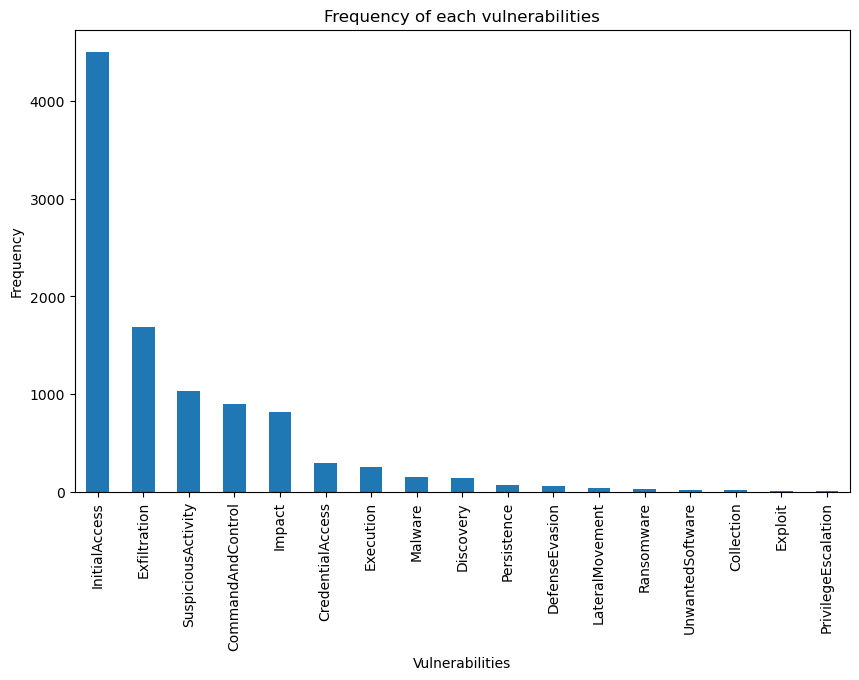

In [17]:
df_train_drop['Category'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title('Frequency of each vulnerabilities')
plt.xlabel('Vulnerabilities')
plt.ylabel('Frequency')
plt.show()

7203
1130
9613
7148


In [120]:
df_train_drop.groupby('SuspicionLevel')['AlertId'].count()

SuspicionLevel
Incriminated       2
Suspicious      1536
Name: AlertId, dtype: int64

In [76]:
df_train_drop['City'].nunique()

196

In [121]:

# Function to calculate Chi-Square for a specific feature against the target feature
def chi_square_test(feature, target):
    contingency_table = pd.crosstab(df_train_drop[feature], df_train_drop[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return p  # Return p-value for significance

# Calculate Chi-Square p-value for each feature against 'TargetFeature'
chi_square_results = {}
for feature in df_train_drop.columns:
    if feature != 'SuspicionLevel':
        p_value = chi_square_test(feature, 'SuspicionLevel')
        chi_square_results[feature] = p_value

sorted(chi_square_results.items(), key=lambda item: item[1], reverse=True)

[('EvidenceRole', 1.0),
 ('DeviceId', 1.0),
 ('IpAddress', 1.0),
 ('Url', 1.0),
 ('DeviceName', 1.0),
 ('NetworkMessageId', 1.0),
 ('ApplicationId', 1.0),
 ('ApplicationName', 1.0),
 ('OAuthApplicationId', 1.0),
 ('ResourceIdName', 1.0),
 ('CountryCode', 1.0),
 ('State', 1.0),
 ('City', 1.0),
 ('RegistryKey', 0.9999999987511806),
 ('IncidentId', 0.9999159177546233),
 ('RegistryValueName', 0.9986970707959312),
 ('RegistryValueData', 0.9986970707959312),
 ('OSVersion', 0.9965459694027967),
 ('OSFamily', 0.838559333955088),
 ('IncidentGrade', 0.7485157700772223),
 ('EntityType', 0.41543184617143725),
 ('Timestamp', 0.40954802297587406),
 ('AlertId', 0.40954802297587084),
 ('Category', 0.0013764811592571445),
 ('LastVerdict', 1.5613575847014523e-05),
 ('AccountName', 1.0638452782994935e-08),
 ('AccountSid', 3.0753393890839742e-09),
 ('AccountUpn', 1.0978598430348542e-09),
 ('AccountObjectId', 2.886298036172306e-10),
 ('OrgId', 8.431928941986343e-57),
 ('Sha256', 3.06340035969818e-59),
 ('F

In [122]:
df_train_drop.groupby('OSFamily')['MitreTechniques'].apply(lambda x: x.fillna(x.mode()[0]))


KeyError: 'Column not found: MitreTechniques'